<h1> Ferrero interview take-home project

Since there was no column meaning explanation given I will use this markdown cell to write down the column meanings as I understand them, so there is a consistency for the readers as they go through the notebook

<b>Loan_ID</b>: Uniquely indentifies the number of the loan case

<b>Gender</b>: The gender of the applicant

<b>Married</b>: The marital status

<b>Dependents</b>: The number of children in the family

<b>Education</b>: The level of education of the applicant

<b>Self_Employed</b>: Is the applicant self-employed?

<b>ApplicantIncome</b>: Applicants income (assuming monthly)

<b>CoapplicantIncome</b>:  Co-applicants income (assuming monthly)

<b>LoanAmount</b>: The loan amount (assuming thousands)

<b>Loan_Amount_Term</b>: How long they will be paying off the loan (assuming months)

<b>Credit_History</b>: The creditworthiness of the applicant.

<b>Property_Area</b>: Where the applicant resides.

<b>Loan_Status</b>: The decision for the loan application

---------------------------------------

In [1]:
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

In [2]:
df_train_initial = pd.read_csv('loan_sanction_train.csv')
df_test_initial = pd.read_csv('loan_sanction_test.csv')

<h1> Excercise 1

<h3>Questions 1-2 ~ Data observe

In [3]:
print('Data shape:', df_train_initial.shape)

Data shape: (614, 13)


In [4]:
df_train = df_train_initial.copy()
df_test = df_test_initial.copy()

display('Data shape:', df_train.shape, 
        df_train.head(5))

'Data shape:'

(614, 13)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
print("Column types of the data:")
print(df_train.dtypes)

Column types of the data:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [6]:
def check_for_odd_values(data):
    """Sometimes searching for null is not enough 
    as there have been cases of finding hardcoded 'null' strings in the data 
    or irrelevant words especially in non-validated data systems
    I will use this ugly function just once to check the values of each column for wrong inputs
    and check for some inconsistencies
    """
    #Check for duplicates
    if data.duplicated(keep=False).sum() == 0:
        print('no duplicated rows')

    #Values check
    data = data.dropna()
    unique_ID = data['Loan_ID'].is_unique
    
    married = data['Married'].nunique()
    education = data['Education'].nunique()
    self_employed = data['Self_Employed'].nunique()
    credit = data['Credit_History'].nunique()
    try:
        label = data['Loan_Status'].nunique()
    except:
        label=2

    
    if unique_ID and education == married == credit == label == 2:
        print('binary columns passed')
    print('')
    print('property area: ', data['Property_Area'].unique())
    print('dependents: ', data['Dependents'].unique())
    print('gender: ', data['Gender'].unique())
    print('')
    
    #Outliers
    threshold = 1.5
    for column in data.select_dtypes(include=['number']):
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        if not outliers.empty:
            print(f"Outliers detected in column '{column}':")
    
check_for_odd_values(df_train)

no duplicated rows
binary columns passed

property area:  ['Rural' 'Urban' 'Semiurban']
dependents:  ['1' '0' '2' '3+']
gender:  ['Male' 'Female']

Outliers detected in column 'ApplicantIncome':
Outliers detected in column 'CoapplicantIncome':
Outliers detected in column 'LoanAmount':
Outliers detected in column 'Loan_Amount_Term':
Outliers detected in column 'Credit_History':


In [7]:
check_for_odd_values(df_test)

no duplicated rows
binary columns passed

property area:  ['Urban' 'Semiurban' 'Rural']
dependents:  ['0' '1' '2' '3+']
gender:  ['Male' 'Female']

Outliers detected in column 'ApplicantIncome':
Outliers detected in column 'CoapplicantIncome':
Outliers detected in column 'LoanAmount':
Outliers detected in column 'Loan_Amount_Term':
Outliers detected in column 'Credit_History':


Except for the null values the other inputs of the dataset seem valid.
There is an indication for outliers but we will examine it better with visualizations later

------------------------------------------

<h2>Question 3-4 ~ Handling Null Values

In [8]:
null_percentage = df_train.isnull().mean() * 100
null_percentage = round(null_percentage, 2)
 
null_counts = df_train.isnull().sum()
null_info = pd.DataFrame({'Percentage': null_percentage, 'Null Count': null_counts})

print("Null values in each column:")
print(null_info[null_info['Null Count'] > 0])

Null values in each column:
                  Percentage  Null Count
Gender                  2.12          13
Married                 0.49           3
Dependents              2.44          15
Self_Employed           5.21          32
LoanAmount              3.58          22
Loan_Amount_Term        2.28          14
Credit_History          8.14          50


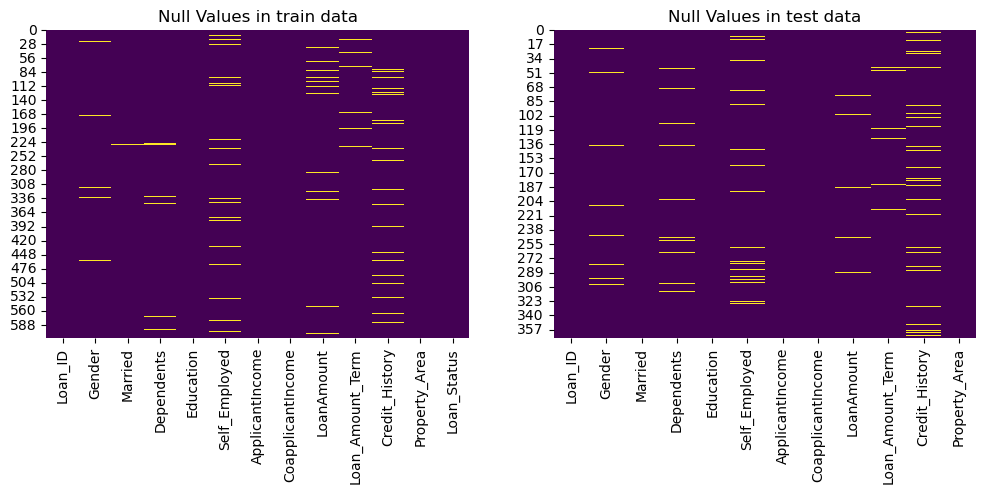

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.heatmap(df_train.isnull(), cmap='viridis', cbar=False)
plt.title('Null Values in train data')

plt.subplot(122)
sns.heatmap(df_test.isnull(), cmap='viridis', cbar=False)
plt.title('Null Values in test data')
plt.show()

<h5> Lets examine ways to address the null values problem

1. Deletion: Remove rows or columns with null values. This is suitable when the null values are relatively few compared to the total dataset and removing them won't significantly affect the analysis.

In [10]:
1 - df_train.dropna().shape[0] / df_train.shape[0] 

0.21824104234527686

As anyone can see deleting all rows containing null values results in deleting around 22% of our dataset. This is a large percentage, especially for this dataset which is relatively small in the first place

2. Forward or Backward Fill: Use the value from the previous or next row to fill null values

This is a technique that should be used in othe types of dataset such us time series where the data of the previous row is highly associated with the next one

3. Predictive Modeling: Use machine learning algorithms to predict missing values based on other features in the dataset.

Basically the scope is to train a model to predict the missing values based on other features in the data. For example KNN imputation. I would like to give this a a shot but maybe it exceeds the scope of the porject.

4. Statistical Imputation: Replace null values with a suitable substitute, such as the mean, median, mode, or a constant value.
   In order to be in place to determine a substitute strategy we should take a quick look to the distributions of the null columns.

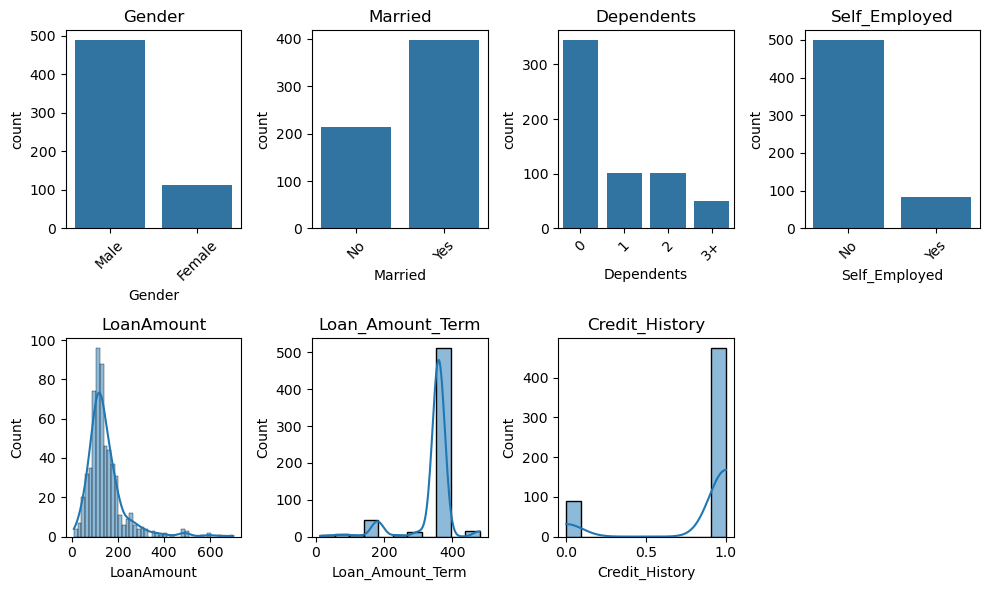

In [11]:
columns_with_nulls = [col for col in df_train.columns if df_train[col].isnull().any()]
df_without_id = df_train.drop('Loan_ID', axis =1)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    num_cols = 4 
    num_rows = (len(columns_with_nulls) + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
    axes = axes.flatten()

    for i, col in enumerate(df_train[columns_with_nulls]):
        if df_without_id[col].dtype == 'object':
            sns.countplot(data=df_without_id, x=col, ax=axes[i])
            #axes[i].set_title(f'Distribution of {col}')
            axes[i].set_title(col)
            axes[i].tick_params(axis='x', rotation=45)
        else:
            sns.histplot(data=df_without_id, x=col, kde=True, ax=axes[i])
            axes[i].set_title(col)

    # Hide the empty
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Most of the categorical columns have a dominant class and I believe it is a good approach to follow the "most frequent" strategy. 
Similarly I will impute the numerical columns with the mean value.

In [12]:
def fixNull(data):
    """Helper function to fillna() 
       with different techniques depending on the column
    """
    null_categorical_cols = list(data[columns_with_nulls].select_dtypes(include=['object']).columns)
    null_numerical_cols = list(data[columns_with_nulls].drop(['Credit_History', 'Loan_Amount_Term'], axis=1).select_dtypes(include=['float64', 'int64']).columns) # I should treat credit history separately
    
    # Categorical Impute
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[null_categorical_cols] = cat_imputer.fit_transform(data[null_categorical_cols])
    
    # Numerical Impute
    num_imputer = SimpleImputer(strategy='mean')
    data[null_numerical_cols] = num_imputer.fit_transform(data[null_numerical_cols])
         
    # Loan Amount Term
    data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
    data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)

    return data

df_train = fixNull(df_train)
df_test = fixNull(df_test)

For the credit history I suspect that it is the most prominent feature and highly correlated with the target so I will try a predictive imputation that 
will consider the relationships of the 'Credit Historly' column with other columns in the dataset based on distance metrics, and accordingly it will impute it.

In [13]:
# # Credit History Impute
# imputer = KNNImputer(n_neighbors=5, weights="distance", metric="nan_euclidean", strategy="most_frequent")
# df_train['Credit_History'] = imputer.fit_transform(df_train[['Credit_History']])

In [14]:
if df_train.isnull().sum().sum()==0:
    print('Train dataset imputed successfully, no null found')

if df_train.isnull().sum().sum()==0:
    print('Test dataset imputed successfully, no null found')

Train dataset imputed successfully, no null found
Test dataset imputed successfully, no null found


The dataset is null-free, so lets do some basic EDA to get a closer view to the data

In [15]:
# Loan_ID is no usefull to the analysis
df_train.drop(columns=['Loan_ID'], inplace=True)
df_test.drop(columns=['Loan_ID'], inplace=True)

categorical_cols = list(df_train.select_dtypes(include=['object']).columns)
numerical_cols = list(df_train.select_dtypes(include=['float64', 'int64']).columns)

print('categorical', categorical_cols)
print('numerical', numerical_cols)

categorical ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
numerical ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


----------------------

<h2>Question 5 ~ EDA

<h3> Outlier detection

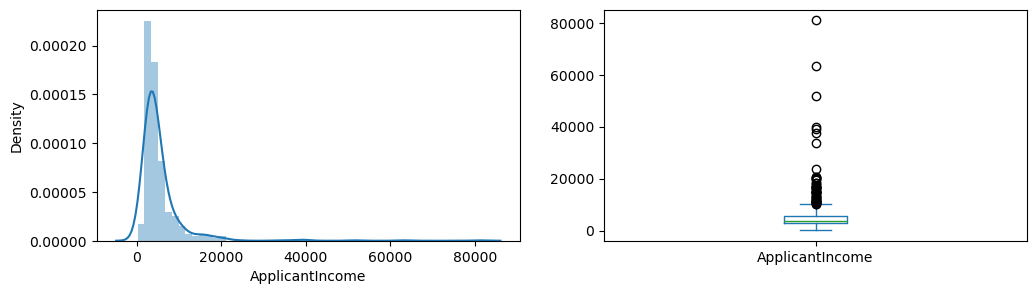

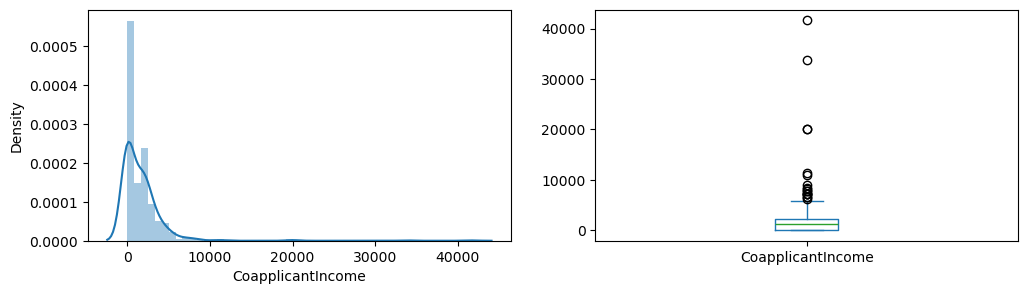

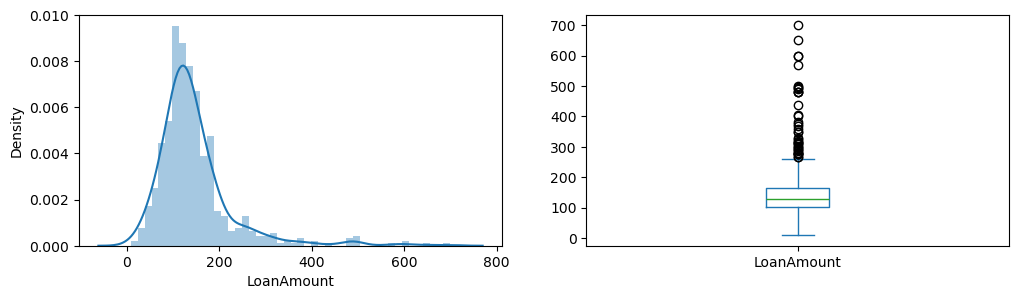

In [16]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    plt.subplot(121)
    sns.distplot(df_train['ApplicantIncome']);
    
    plt.subplot(122)
    df_train['ApplicantIncome'].plot.box(figsize=(12,3))
    plt.show()
    print('')
    
    plt.subplot(121)
    sns.distplot(df_train['CoapplicantIncome']);
    
    plt.subplot(122)
    df_train['CoapplicantIncome'].plot.box(figsize=(12,3))
    
    plt.show()
    print('')

    plt.subplot(121)
    sns.distplot(df_train['LoanAmount']);
    
    plt.subplot(122)
    df_train['LoanAmount'].plot.box(figsize=(12,3))
    
    plt.show()

It is visible through these graphs that all these 3 numerical variables contain outliers that may cause trouble at the model section. 
The distribution is right-skewed (positive skewness) especially in the 2 incomes variables. We will deal with that before the model part

<Figure size 1000x1200 with 0 Axes>

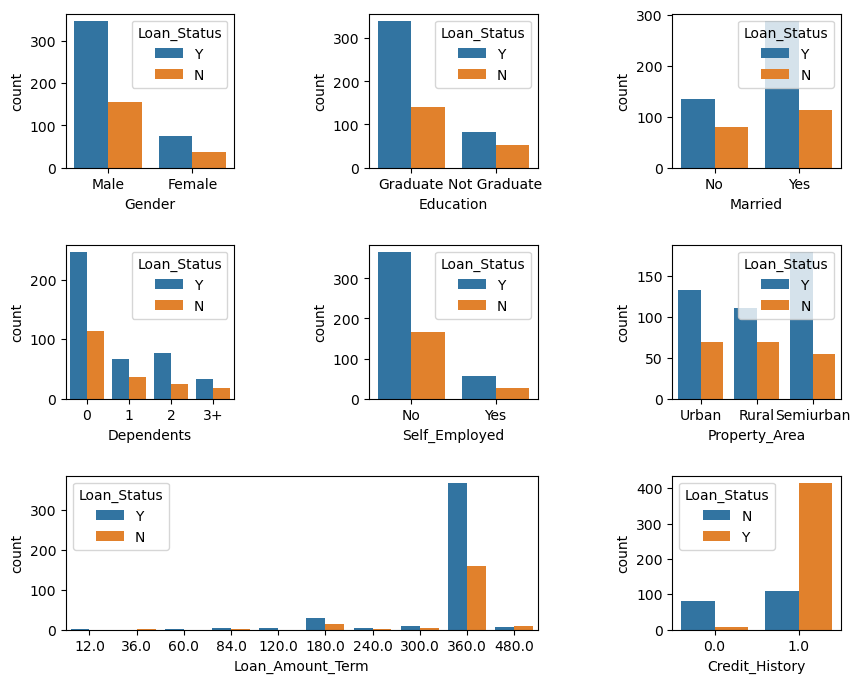

In [17]:
plt.figure(figsize=(10, 12))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.8, hspace=0.5) 
plt.subplot(331)

sns.countplot(df_train, x="Gender" , hue="Loan_Status");

plt.subplot(332)
sns.countplot(df_train, x="Education" , hue="Loan_Status");

plt.subplot(333)
sns.countplot(df_train, x="Married" , hue="Loan_Status");

plt.subplot(334)
sns.countplot(df_train, x="Dependents" , hue="Loan_Status");

plt.subplot(335)
sns.countplot(df_train, x="Self_Employed" , hue="Loan_Status");

plt.subplot(336)
sns.countplot(df_train, x="Property_Area" , hue="Loan_Status");

plt.subplot(3,3,(7, 8))
sns.countplot(df_train, x="Loan_Amount_Term" , hue="Loan_Status");
                            
plt.subplot(3,3,9)
sns.countplot(df_train, x="Credit_History" , hue="Loan_Status");

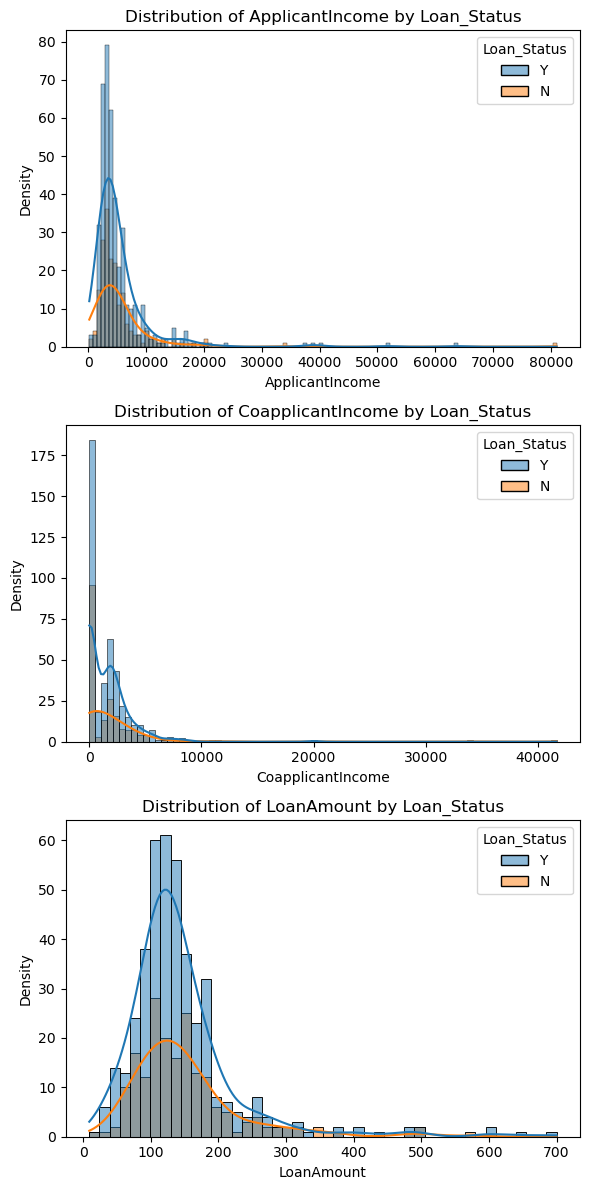

In [18]:
distribution_list_num = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
fig, axes = plt.subplots(nrows=len(distribution_list_num), ncols=1, figsize=(6, 4 * len(distribution_list_num)))

# Iterate over numerical columns and plot distribution for each
for i, col in enumerate(distribution_list_num):
    sns.histplot(data=df_train, x=col, hue='Loan_Status', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Loan_Status')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

-----------------------------

<h2>Questions 6-10 ~ Preprocessing before the modeling part

Check for multicoliniarity

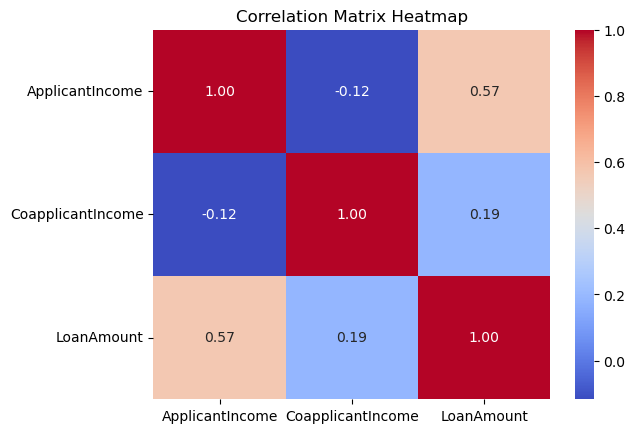

In [19]:
df_cor_num = df_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]
correlation_matrix =df_cor_num.corr()

# Step 2: Visualize Correlation Matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [20]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df_cor_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_cor_num.values, i) for i in range(df_cor_num.shape[1])]
vif_data

,Variable,VIF
0,ApplicantIncome,2.834857
1,CoapplicantIncome,1.451167
2,LoanAmount,3.564141


In [21]:
df_cor_cat = df_train[categorical_cols]

In [22]:
df_cor_cat = pd.get_dummies(df_cor_cat[categorical_cols], drop_first=True)

In [23]:
corr_matrix = df_cor_cat.corr()
threshold = 0.3
high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)


for i, j in zip(*high_corr_pairs):
    if i != j and i < j:  # Avoid duplicate pairs and self-correlations
        print(f"Highly correlated pair: {df_cor_cat.columns[i]} - {df_cor_cat.columns[j]} (Correlation: {corr_matrix.iloc[i, j]:.2f})")

Highly correlated pair: Gender_Male - Married_Yes (Correlation: 0.36)
Highly correlated pair: Property_Area_Semiurban - Property_Area_Urban (Correlation: -0.55)


-----------------------------------

Outliers handling

In [24]:
train = df_train.copy()
test = df_test.copy()

Text(0.5, 1.0, 'Loan Amount')

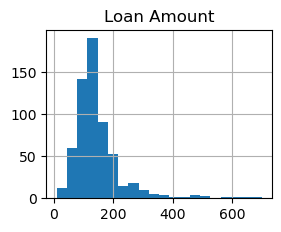

In [25]:
plt.subplot(221)
train['LoanAmount'].hist(bins=20)
plt.title('Loan Amount')

In [26]:
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
test['TotalIncome'] = test['ApplicantIncome'] + test['CoapplicantIncome']

In [27]:
def log_variables(x):
    if x>0:
        return np.log(x)
    else:
        return 0

columns_with_outliers = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'TotalIncome']

train[columns_with_outliers] = train[columns_with_outliers].applymap(log_variables)
train.rename(columns={col: col + '_log' for col in columns_with_outliers}, inplace=True)

test[columns_with_outliers] = test[columns_with_outliers].applymap(log_variables)
test.rename(columns={col: col + '_log' for col in columns_with_outliers}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15688\623744399.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train[columns_with_outliers] = train[columns_with_outliers].applymap(log_variables)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15688\623744399.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test[columns_with_outliers] = test[columns_with_outliers].applymap(log_variables)


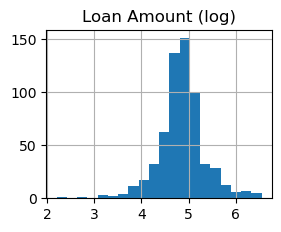

In [28]:
plt.subplot(221)
train['LoanAmount_log'].hist(bins=20)
plt.title('Loan Amount (log)')
plt.show()


-------------------------------------

Train-Test Split

In [29]:
dropList = ['ApplicantIncome_log', 'CoapplicantIncome_log']
test = test.drop(columns=dropList)
dropList.append('Loan_Status')
X = train.drop(columns=dropList, axis = 1)
y = train['Loan_Status']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (552, 10) (552,)
Validation set shape: (62, 10) (62,)


When specifying a random seed the split method uses this values to  generate random indices for splitting the data into training and validation sets. 
This ensures that the random numbers generated by this code will be reproducible in future runs

Here I will re-set the variables in the 2 lists

In [30]:
#numerical_cols = ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']
numerical_cols = ['TotalIncome_log', 'LoanAmount_log']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term', 'Credit_History']


#numerical_transformer = MinMaxScaler()
numerical_transformer = StandardScaler()
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_val_preprocessed = preprocessing_pipeline.transform(X_val)
X_test_preprocessed = preprocessing_pipeline.transform(test)

In [31]:
def create_rf_model(gridSearch, metric):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        if gridSearch:
            param_grid = {
            'n_estimators': [20, 50, 100],
            'max_depth': [2, 4, 6],
            'min_samples_split': [2, 5, 8],
            'min_samples_leaf': [2, 4],
             }
  
            rf_model = RandomForestClassifier(random_state=42)
             
            grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=metric)
     
            grid_search.fit(X_train_preprocessed, y_train)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            print(best_params)
            rf_model = RandomForestClassifier(**best_params, random_state=42)
            
        else:
            rf_model = RandomForestClassifier(n_estimators=20, 
                                              max_depth=2, 
                                              min_samples_split=2, 
                                              min_samples_leaf=2, 
                                              class_weight='balanced', 
                                              random_state=42)
            
    return rf_model
            
    
basic_model = create_rf_model(False, 'precision')
basic_model.fit(X_train_preprocessed, y_train)
y_train_pred = basic_model.predict(X_train_preprocessed)
y_val_pred = basic_model.predict(X_val_preprocessed)

In [32]:
print("Performance on the training set:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred, pos_label='Y'))
print("Recall:", recall_score(y_train, y_train_pred, pos_label='Y'))
print("F1-score:", f1_score(y_train, y_train_pred, pos_label='Y'))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

Performance on the training set:
Accuracy: 0.8260869565217391
Precision: 0.8145695364238411
Recall: 0.968503937007874
F1-score: 0.8848920863309353
Confusion Matrix:
[[ 87  84]
 [ 12 369]]


In [33]:
print("\nPerformance on the validation set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, pos_label='Y'))
print("Recall:", recall_score(y_val, y_val_pred, pos_label='Y'))
print("F1-score:", f1_score(y_val, y_val_pred, pos_label='Y'))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Performance on the validation set:
Accuracy: 0.7741935483870968
Precision: 0.7547169811320755
Recall: 0.975609756097561
F1-score: 0.851063829787234
Confusion Matrix:
[[ 8 13]
 [ 1 40]]


----------------------------

Feature importances

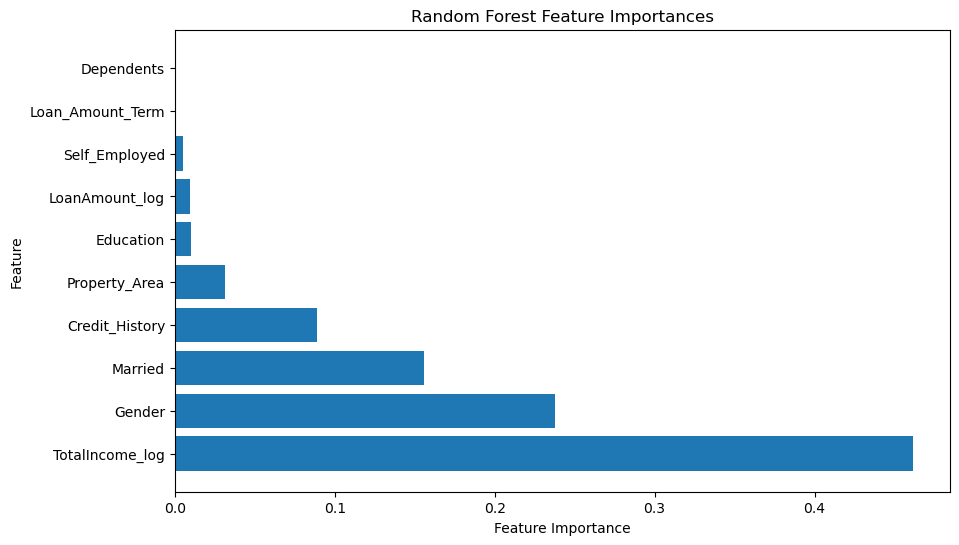

In [34]:
def extractFeatureImportances(model_name):
    """Extracts and plots feature importances 
    for the RF model sorted by importance
    """

    feature_importances = model_name.feature_importances_
    feature_names = X_train.columns

    sorted_indices = feature_importances.argsort()[::-1]
    sorted_importances = feature_importances[sorted_indices]
    sorted_names = feature_names[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Random Forest Feature Importances')
    plt.show()
    
    
extractFeatureImportances(basic_model)

--------------------------

Using Cross-Validation

In [35]:
rf_model_cv = RandomForestClassifier(n_estimators=20, 
                                     max_depth=2, 
                                     min_samples_split=2, 
                                     min_samples_leaf=2, 
                                     class_weight='balanced',
                                     random_state=42)

In [36]:
X_preprocessed = preprocessing_pipeline.fit_transform(X)

In [37]:
custom_scorer = make_scorer(f1_score, pos_label='Y')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model_cv, X_preprocessed, y, cv=kf, scoring=custom_scorer)

print("Cross-Validation Scores (F1-score):", cv_scores)
print("Average score:", cv_scores.mean())

Cross-Validation Scores (F1-score): [0.81609195 0.87912088 0.86956522 0.86315789 0.87234043]
Average score: 0.8600552741607859


In [38]:
rf_model_cv.fit(X_preprocessed, y)

RandomForestClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       n_estimators=20, random_state=42)

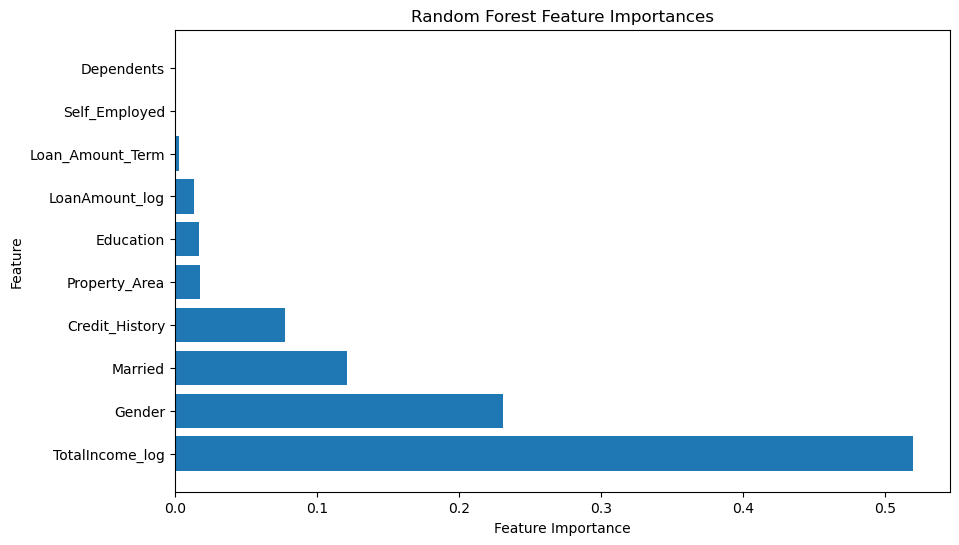

In [39]:
extractFeatureImportances(rf_model_cv)

In [40]:
predictions = rf_model_cv.predict(X_test_preprocessed)

In [41]:
def export(model, model_filename, csv_name):
    dump(rf_model_cv, model_filename)
    
    df_test_initial['Loan_Status_Prediction'] = predictions
    df_test_initial.to_csv(csv_name)

In [42]:
#export(rf_model_cv, 'rf_model_cv.joblib', 'test_predictions_df.csv' )

------------------------ 

------------------------ 

<h1> Excercise 2

In [43]:
# Re-initiate because I need to preprocess differently in terms of logs
train = df_train.copy()
test = df_test.copy()

In [44]:
columns_with_outliers = ['LoanAmount', 'CoapplicantIncome']

train[columns_with_outliers] = train[columns_with_outliers].applymap(log_variables)
train.rename(columns={col: col + '_log' for col in columns_with_outliers}, inplace=True)

test[columns_with_outliers] = test[columns_with_outliers].applymap(log_variables)
test.rename(columns={col: col + '_log' for col in columns_with_outliers}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15688\3046191811.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train[columns_with_outliers] = train[columns_with_outliers].applymap(log_variables)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15688\3046191811.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test[columns_with_outliers] = test[columns_with_outliers].applymap(log_variables)


In [45]:
# Define the target variable (ApplicantIncome)
X = train.drop(columns=["ApplicantIncome", "Loan_Status"])
y = train["ApplicantIncome"]
X_test = test.drop(columns=["ApplicantIncome"])
y_test = test["ApplicantIncome"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (552, 10) (552,)
Validation set shape: (62, 10) (62,)


In [46]:
numerical_cols = ['CoapplicantIncome_log', 'LoanAmount_log']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term', 'Credit_History']



preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])




X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
x_val_preprocessed = preprocessing_pipeline.transform(X_val)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

In [47]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_preprocessed, y_train)


y_pred = linear_reg_model.predict(X_val_preprocessed)

In [48]:
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.0f}")
print('')
print('Linear Regression Feature Importance:')
coefficients_prior = linear_reg_model.coef_
feature_names = X.columns

coefficients_regression_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients_prior
})

coefficients_regression_df

Mean Absolute Error (MAE): 3508

Linear Regression Feature Importance:


,Feature,Coefficient
0,Gender,-2039.566841
1,Married,2741.861718
2,Dependents,906.607034
3,Education,833.753360
4,Self_Employed,23.915123
5,CoapplicantIncome_log,-918.343588
6,LoanAmount_log,921.413913
7,Loan_Amount_Term,69.375301
8,Credit_History,-247.769062
9,Property_Area,69.117203


In [49]:
n = X_train_preprocessed.shape[0]
p = X_train_preprocessed.shape[1]

In [50]:
residuals = y_train - linear_reg_model.predict(X_train_preprocessed)
residual_variance = np.sum(residuals ** 2) / (n - p)
error_coef = np.sqrt(np.diag(residual_variance * np.linalg.inv(X_train_preprocessed.T @ X_train_preprocessed)))

In [51]:
explainer_linear = shap.Explainer(linear_reg_model, X_train_preprocessed)
shap_values = explainer_linear.shap_values(X_train_preprocessed)

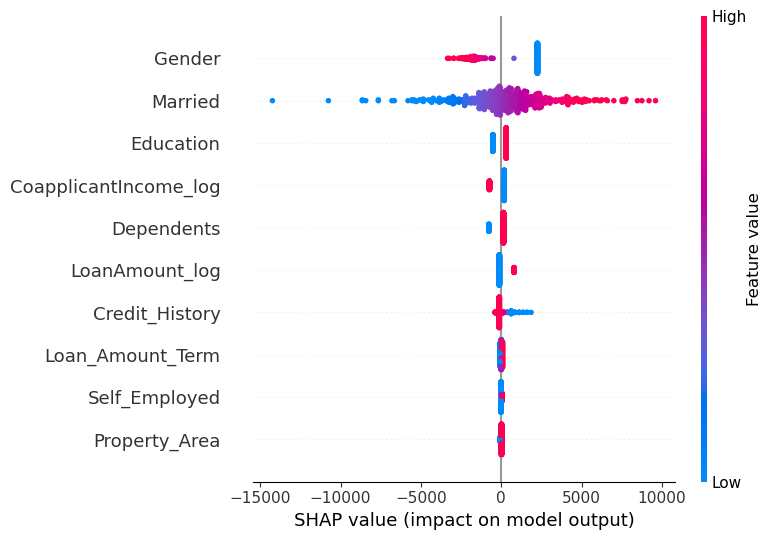

In [52]:
shap.summary_plot(shap_values, X_train_preprocessed, feature_names=X_train.columns)

Bayesian Regression

In [55]:
bayes_model = BayesianRidge(n_iter=100, alpha_1=(error_coef**(-2)).mean())

# Set model priors based on linear regression results
bayes_model.coef_ = coefficients_prior

In [56]:
# Fit the model on the test data
bayes_model.fit(X_test_preprocessed, y_test) 

BayesianRidge(alpha_1=1.9736135273341752e-05, n_iter=100)

In [57]:
y_pred = bayes_model.predict(X_test_preprocessed)

In [58]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.0f}")

posterior_coefficients = bayes_model.coef_

feature_names = X.columns
print('Bayesian Ridge Regression Feature Importance:')
print('')
coefficients_bayes_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": posterior_coefficients
})

coefficients_bayes_df

Mean Absolute Error (MAE): 1892
Bayesian Ridge Regression Feature Importance:



,Feature,Coefficient
0,Gender,-1493.118500
1,Married,2180.314191
2,Dependents,708.262725
3,Education,34.136456
4,Self_Employed,487.802563
5,CoapplicantIncome_log,-873.947050
6,LoanAmount_log,479.860009
7,Loan_Amount_Term,303.040139
8,Credit_History,-61.977972
9,Property_Area,939.563520


In [59]:
explainer_bayes = shap.Explainer(bayes_model, X_test_preprocessed)
shap_values = explainer_bayes.shap_values(X_test_preprocessed)

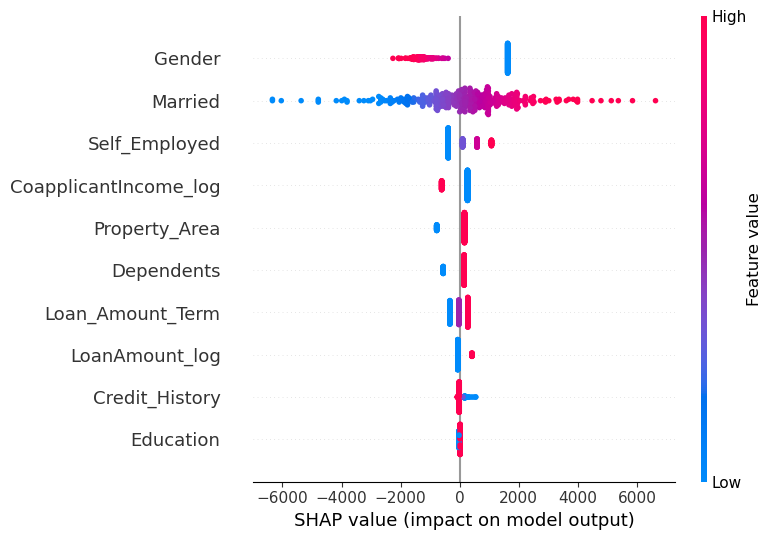

In [60]:
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=X_train.columns)